In [1]:

%pip install -U langchain langchain_community tiktoken langchain-nomic "nomic[local]" \
    langchain-ollama langchain-experimental scikit-learn langgraph tavily-python bs4 langchain_huggingface \
        "langserve[server]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [langserve]/5 [fastapi]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
### LLM
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()
base_url="http://192.168.0.108:11434"
local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0, base_url=base_url)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json", base_url=base_url)

In [ ]:
import os
import json
import operator
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing import Sequence, TypedDict, Any, List, Annotated
from langchain_ollama import ChatOllama
from langchain.schema import Document
from langgraph.graph import END
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableConfig

from dotenv import load_dotenv

In [3]:
### Vector Store in Memory
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore, InMemoryVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain.vectorstores import Qdrant

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
# # Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

# Create a vector store
# qdrant_url = "http://192.168.0.108:6333"
# vectorstore = Qdrant.from_documents(documents=doc_splits, url=qdrant_url, embedding=embeddings, collection_name="ai-agents-collection")

# Create retriever
retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Embedding texts: 100%|██████████| 47/47 [01:49<00:00,  2.33s/inputs]


In [4]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions), HumanMessage(content="Who is favored to win the NFC Championship game in the 2024 season?")]
)
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama3.2?")]
)
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of agent memory?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [5]:
### Web search tool - Serperdev 
import os
import pydantic
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool
from dotenv import load_dotenv


# This loads the .env file in the current directory, if it exists.
load_dotenv()

# or add API key manually below
# os.environ["SERPER_API_KEY"] = "changeme"


search = GoogleSerperAPIWrapper()
web_search_tool = Tool(
        name="Intermediate Answer",
        func=search.run,
        description="useful for when you need to ask with search", 
        
    )
question = "What is the hometown of the reigning men's U.S. Open champion?"
print(web_search_tool.invoke({"query": question}))


Newport (1881–1914), Forest Hills (1915–1920, 1924–1977), and Philadelphia (1921–1923) held the event before it settled in 1978. The tournament originally took place in Newport, Rhode Island from its inception until 1914. It is the only Grand Slam that was not affected by cancellation due ... Discover the rich history of the US Open Tennis Championships with our year-by-year archive of tournament highlights and memorable moments. Huntington's Jack Kennedy was awarded a wild card into the U.S. Open men's qualifying singles tournament, the USTA announced Wednesday. 1st US National Championship Men's Tennis, Newport RI: Richard Sears wins inaugural event beating William E. Glyn 6-0, 6-3, 6-2. Dating back to 1881 until today check out the past champions of the US Open Tennis Championships. See scores and opponents in each year's US Open finals ... At 25 years old, Ashe became a US Open Champion, defeating a field of tennis greats, including Australia's Rod Laver, Tony Roche, Ken Rosewall, 

In [6]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question} \n\n. 

Think carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
# print(docs)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 21.12inputs/s]


{'binary_score': 'yes'}

In [7]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 18.27inputs/s]


Chain-of-Thought (CoT) prompting is a technique used in natural language processing that generates a sequence of short sentences to describe reasoning logics step by step, known as reasoning chains or rationales, to eventually lead to the final answer. This method was first introduced by Wei et al. (2022) and has been further developed in various research papers, including Tree of Thoughts (Yao et al., 2023), which extends CoT by exploring multiple reasoning possibilities at each step. CoT prompting is particularly useful for complicated reasoning tasks, where it can help models to provide more transparent and explainable answers.


In [8]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'no',
 'explanation': 'The student answer does not meet all of the criteria because it only mentions Chain-of-Thought (CoT) prompting without referencing any specific research papers or techniques such as Tree of Thoughts, Self-Ask, or Automatic Prompt Design. The student also fails to provide a clear explanation of how CoT prompting is used in natural language processing and its benefits for complicated reasoning tasks.'}

In [9]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# Test
# question = "What are the vision models released today as part of Llama 3.2?"
# answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer meets all the criteria for the question. Here's why:\n\n1. The answer provides a clear definition of Chain-of-Thought prompting: The student defines CoT as a technique that generates a sequence of short sentences to describe reasoning logics step by step.\n\n2. The answer mentions the introduction of CoT by Wei et al. (2022): The student correctly states that CoT was first introduced in 2022, which is consistent with the question's information.\n\n3. The answer highlights the extension of CoT by Tree of Thoughts (Yao et al., 2023): The student mentions a specific research paper that extends CoT, demonstrating their understanding of the topic.\n\n4. The answer explains the usefulness of CoT prompting: The student correctly states that CoT is particularly useful for complicated reasoning tasks, which aligns with the question's information.\n\n5. The answer provides additional context and details: The student includes extra inf

# LangGraph - State

Graph state. The graph state schema contains keys that we want to:

- Pass to each node in our graph
- Optionally, modify in each node of our graph

In [10]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

# LangGraph - nodes and edges for LangChain's langgraph
Each node in our graph is simply a function that:

(1) Take state as an input. See conceptual notes aboute Graph state [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

(2) Modifies state

(3) Write the modified state to the state schema (dict)

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes).

Each edge routes between nodes in the graph.

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

In [11]:
from langchain.schema import Document
from langgraph.graph import END


### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENTS RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
            web_search = "No"
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    web_results = web_search_tool.invoke({"query": question})
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


### Edges


def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers the question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

# Control Flow

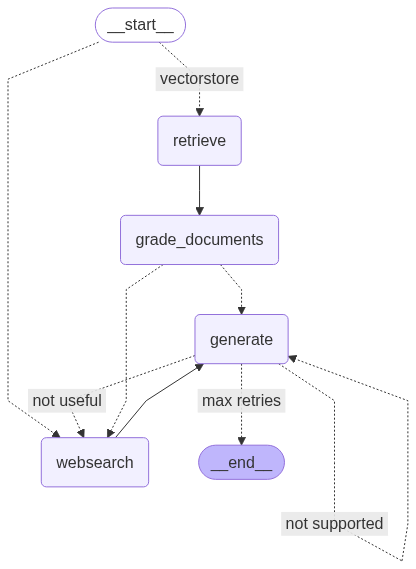

In [12]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate


workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:

# # Testing
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 14.71inputs/s]

{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '98d91e00-18e3-4954-97f2-09d4071453ea', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-c

---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'question': 'What are the types of agent memory?', 'web_search': 'Yes', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '98d91e00-18e3-4954-97f2-09d4071453ea', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the a